## Image GPT [https://openai.com/blog/image-gpt/](https://openai.com/blog/image-gpt/)

Demo notebook. Please follow the `Readme.md` file and install all the requiresments if you didn't already

In [ ]:
# Run to check your nvidia card memory (optional)
!nvidia-smi

In [19]:
import cv2
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shutil import copy2
from datetime import datetime

from src.np_utils import color_quantize_np, generate_primer
# from src.runner import run_preds

model_size = "m"  # ["s", "m", "l"] available (xl, which is used on the website, is not avaiable)
gpus = 1
n_samples = 32
size = 32  # depends on the model: 32, *48, *64 (48 and 64 are only avaiable with XL model)

model_dir = "models"
color_clusters_dir = "clusters"
timestamp = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')

### Download model (run only once, if you have a model stored in `{model_dir}` then skip)

Depends on your selection, get the right model and color cluster

_This might take a while depends on your internet connection_

In [8]:
# Uncomment this code to download model and color cluster
# !python download.py --model {model_size} --ckpt 1000000 --clusters --download_dir {model_dir}/{model_size}
# !python download.py --clusters --download_dir {color_clusters_dir}

input args:
 {
    "download_dir":"models/l-small",
    "bert":false,
    "model":"l",
    "ckpt":"131000",
    "clusters":true,
    "dataset":null
}
Fetching model.ckpt-131000.data-00000-of-00064: 1.00kit [00:00, 707kit/s]       
Fetching model.ckpt-131000.data-00001-of-00064: 252Mit [00:21, 11.5Mit/s]       
Fetching model.ckpt-131000.data-00002-of-00064: 249Mit [00:21, 11.5Mit/s]       
Fetching model.ckpt-131000.data-00003-of-00064: 249Mit [00:20, 12.0Mit/s]       
Fetching model.ckpt-131000.data-00004-of-00064: 274Mit [00:23, 11.6Mit/s]       
Fetching model.ckpt-131000.data-00005-of-00064: 255Mit [00:21, 12.0Mit/s]       
Fetching model.ckpt-131000.data-00006-of-00064: 255Mit [00:20, 12.6Mit/s]       
Fetching model.ckpt-131000.data-00007-of-00064: 264Mit [00:21, 12.2Mit/s]       
Fetching model.ckpt-131000.data-00008-of-00064: 245Mit [00:21, 11.6Mit/s]       
Fetching model.ckpt-131000.data-00009-of-00064: 258Mit [00:20, 12.5Mit/s]       
Fetching model.ckpt-131000.data-00010-of

## Get image and create inputs

In [2]:
# This one is optional if you don't have anything stored
!curl https://www.vectorkhazana.com/assets/images/products/Disney-Baby-Yoda-Disney.jpg > test_input2.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44269  100 44269    0     0  41450      0  0:00:01  0:00:01 --:--:-- 41450


In [3]:
image_path = 'test_input2.jpg' # Change this you you already have an image on your machine
batch = [image_path]*(gpus*n_samples)

dim=(size,size)

x = np.zeros((gpus*n_samples,size,size,3),dtype=np.uint8)

for n,image_path in enumerate(batch):
    img_np = cv2.imread(image_path)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)   # BGR -> RGB, default one is BGR and we need RGB
    H,W,C = img_np.shape
    D = min(H,W)
    img_np = img_np[:D,:D,:C] # crop square image with shorter dim
    x[n] = cv2.resize(img_np,dim, interpolation = cv2.INTER_AREA)

## Visualize batch

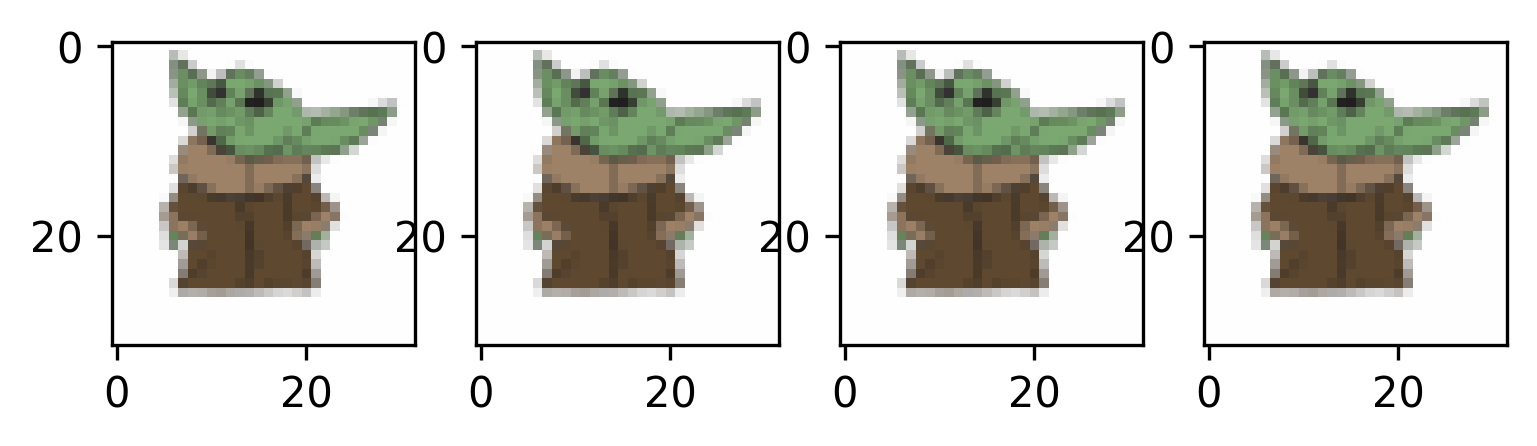

In [4]:
fig, ax = plt.subplots(1,n_samples, dpi=300)

i = 0
for img in x:
    ax[i].imshow(img)
    i += 1

In [5]:
color_cluster_path = f"{color_clusters_dir}/kmeans_centers.npy"
primers = generate_primer(image_path, n_samples, gpus, size, color_cluster_path)

## Visualize cropped images

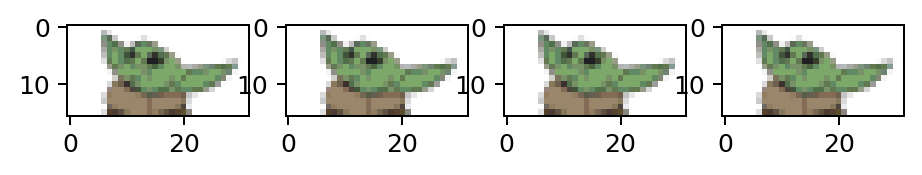

In [6]:
n_px_crop = 16 # do not change, it's the same as in `generate_primer` method
clusters = np.load(color_cluster_path)
primers_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px_crop,size, 3]).astype(np.uint8) for s in primers] # convert color clusters back to pixels

fig, ax = plt.subplots(1,n_samples,dpi=180)
i = 0
for img in primers_img:
    ax[i].imshow(img)
    i += 1

## Define arguments and method call

In [7]:
#set model hyperparameters
MODELS={"l":(1536,16,48),"m":(1024,8,36),"s":(512,8,24) }
n_embd,n_head,n_layer=MODELS[model_size]

## Generate n_samples for a given primer
Samples are stored in `out/` dir. This might take a while to execute, depends on your GPU. If you're geting an error, try smaller model (i.e. `model_size = "s"`). If it's taking too long then decrease `n_samples`.

In [20]:
# Runs sampling for a given primer
!python src/run.py --sample --n_embd {n_embd} --n_head {n_head} --n_layer {n_layer} --ckpt_path {model_dir}/{model_size}/model.ckpt-1000000  --color_cluster_path {color_clusters_dir}/kmeans_centers.npy --save_dir out --n_gpu 1 --n_px {size} --n_sub_batch {n_samples} --seed 0 --primer {image_path}

input args:
 {
    "data_path":"/root/downloads/imagenet",
    "ckpt_path":"models/m/model.ckpt-1000000",
    "color_cluster_path":"clusters/kmeans_centers.npy",
    "save_dir":"out",
    "n_embd":1024,
    "n_head":8,
    "n_layer":36,
    "n_px":32,
    "n_vocab":512,
    "bert":false,
    "bert_mask_prob":0.15,
    "clf":false,
    "n_sub_batch":32,
    "n_gpu":1,
    "eval":false,
    "sample":true,
    "seed":0,
    "primer":"test_input2.jpg"
}
Instructions for updating:
Colocations handled automatically by placer.
trainable parameters: 455157760
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [21]:
# Copy results to temp folder with postfix
for i in range(gpus*n_samples):
    source_path = f'out/sample_{i}.png'
    dest_path = f'copies/sample_{i}_{timestamp}.png'
    if os.path.isfile(dest_path):
        print(f"Cannot copy {source_path}.png to {dest_path}, file already exists")
    else:
        copy2(source_path, dest_path)

## Print currently stored samples

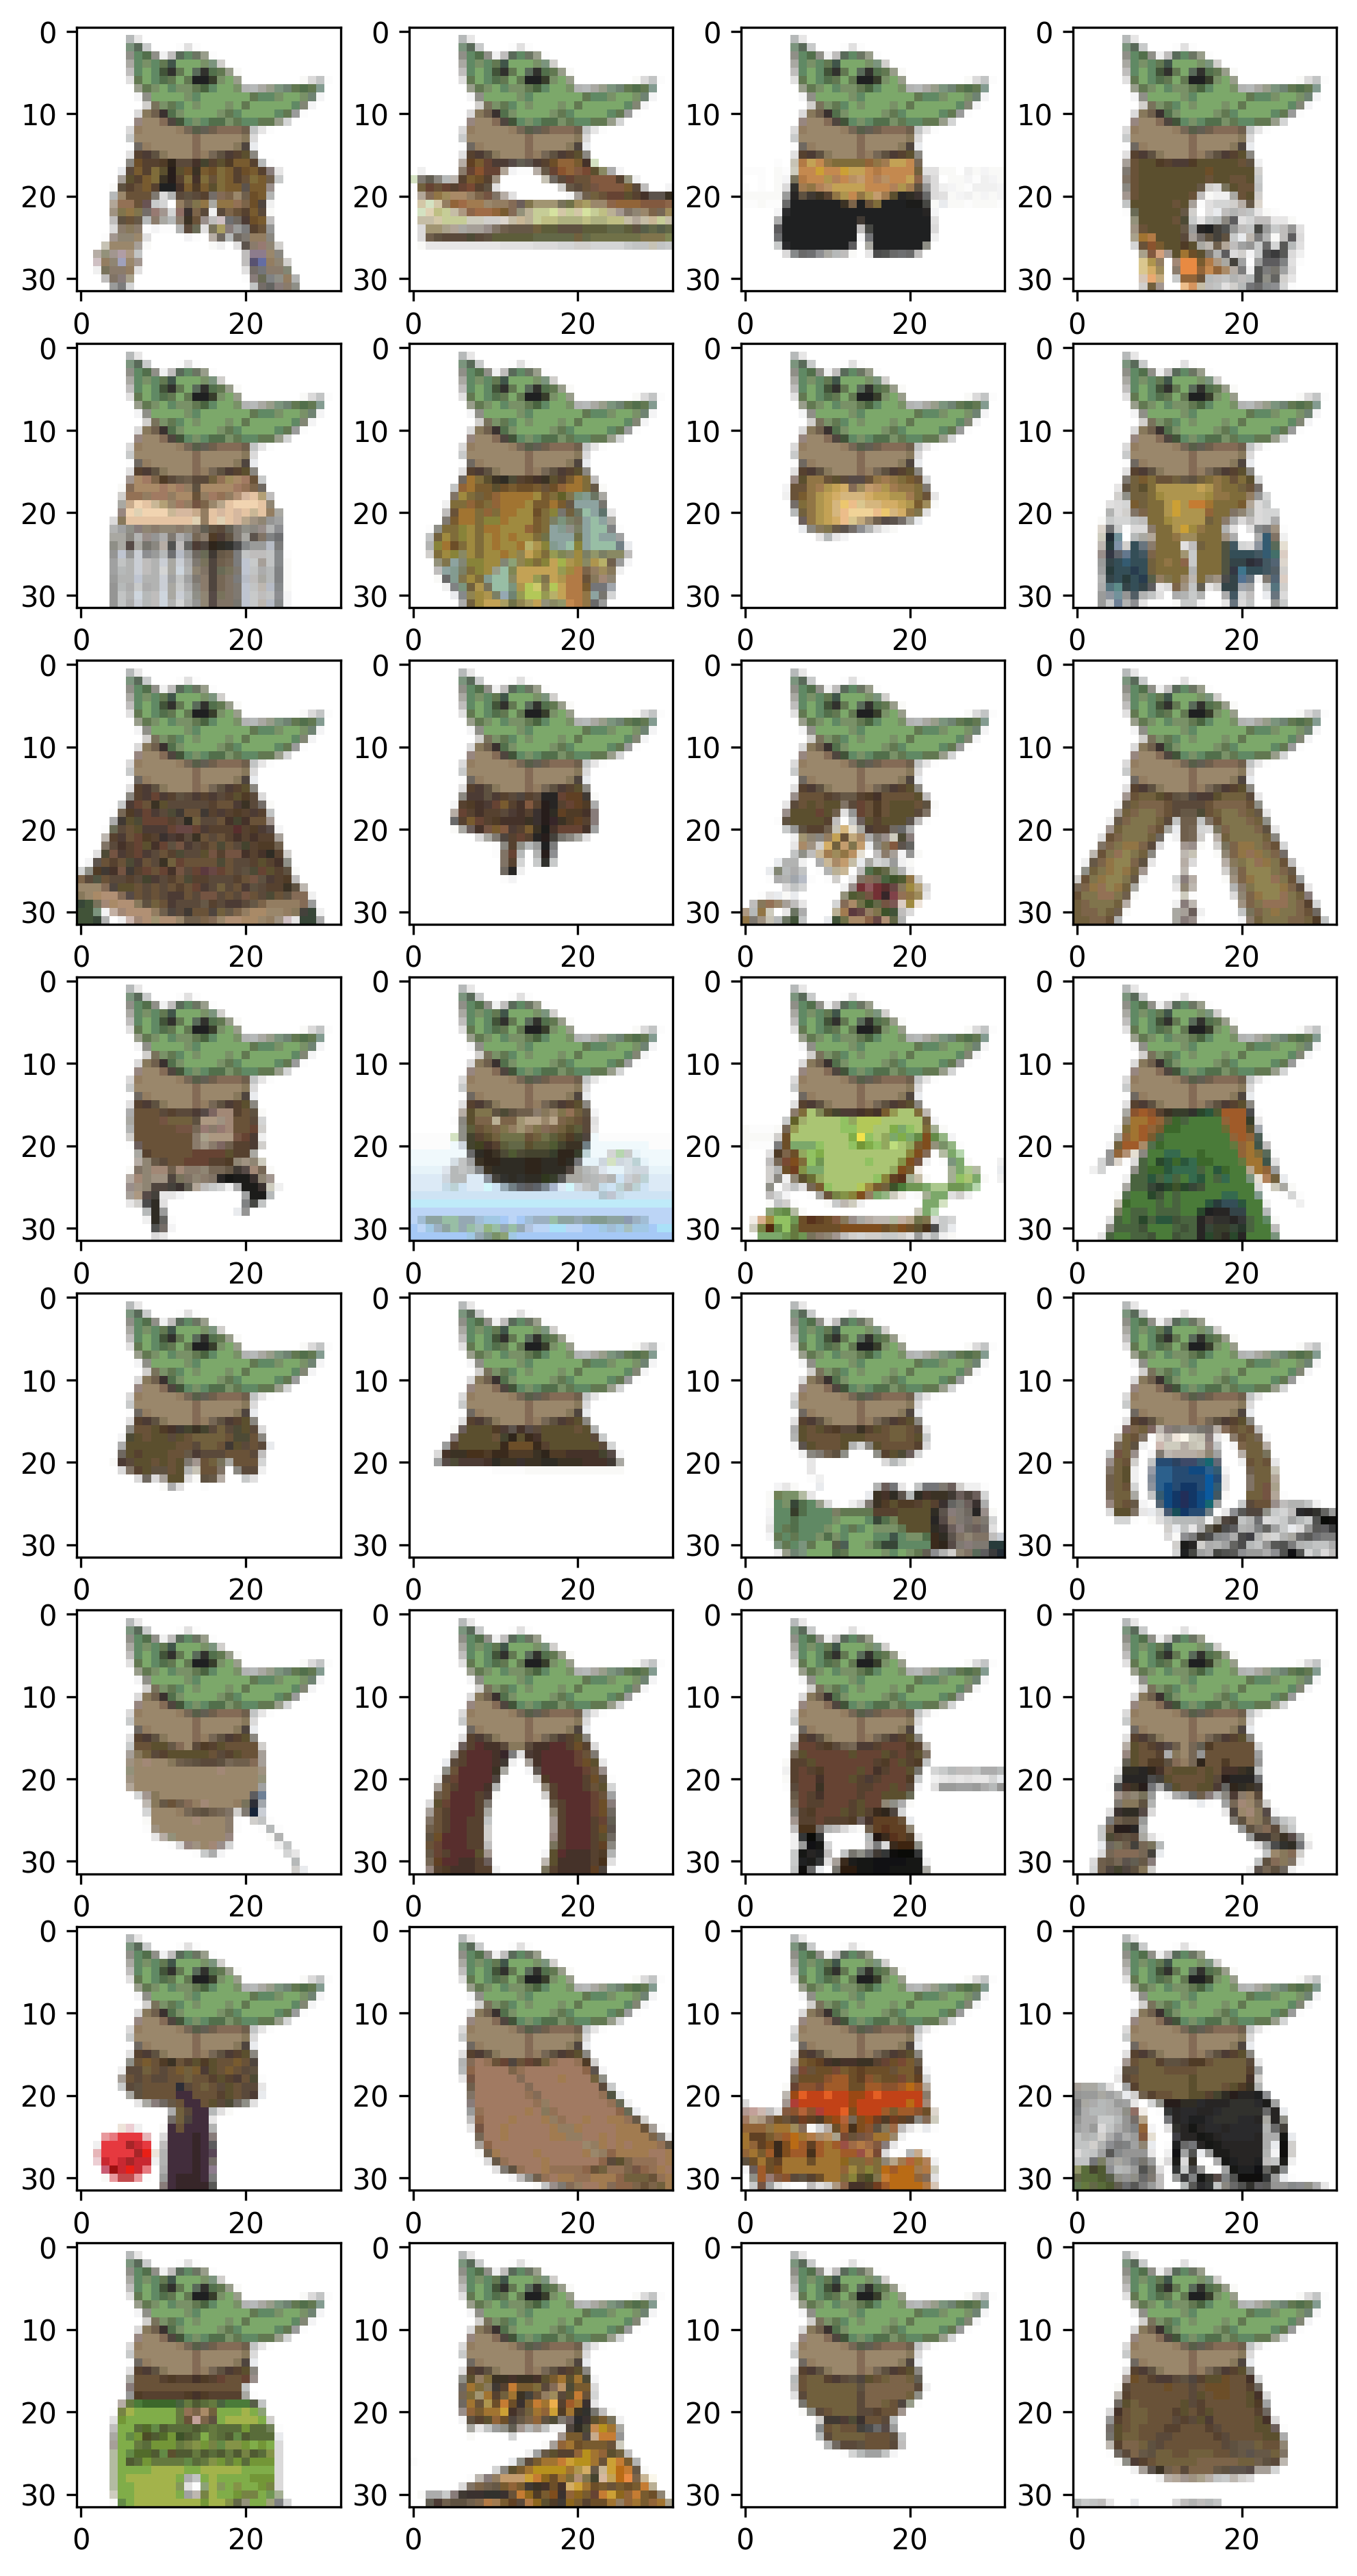

In [22]:
num_columns = 4
num_rows = int(gpus*n_samples/num_columns)
fig, ax = plt.subplots(num_rows,num_columns, dpi=300, figsize = (2*num_columns,2*num_rows))

i = 0
for i in range(num_rows):
    for j in range(num_columns):
        idx = i*num_columns+j
        source_path = f'out/sample_{idx}.png'
        image = plt.imread(source_path)
        if num_rows > 1:
            ax[i, j].imshow(image, interpolation="none")
        else:
            ax[j].imshow(image, interpolation="none")
    i += 1
    
plt.show()

# Interpolated images (ESRGAN)

[Github repo](https://github.com/xinntao/ESRGAN), this not always works for very small images (32x32) but if an image has less details (like clipart) then it's enough.

This is not part of the repository, you should download ESRGAN and copy `out/*.png` files into `LR/` folder in ESRGAN project and then follow instruction in [README](https://github.com/xinntao/ESRGAN#esrgan-enhanced-srgan-rocket-basicsredvr)

If you run and generate upscalled samples copy them into `inter/*.png` so you can run the code below.

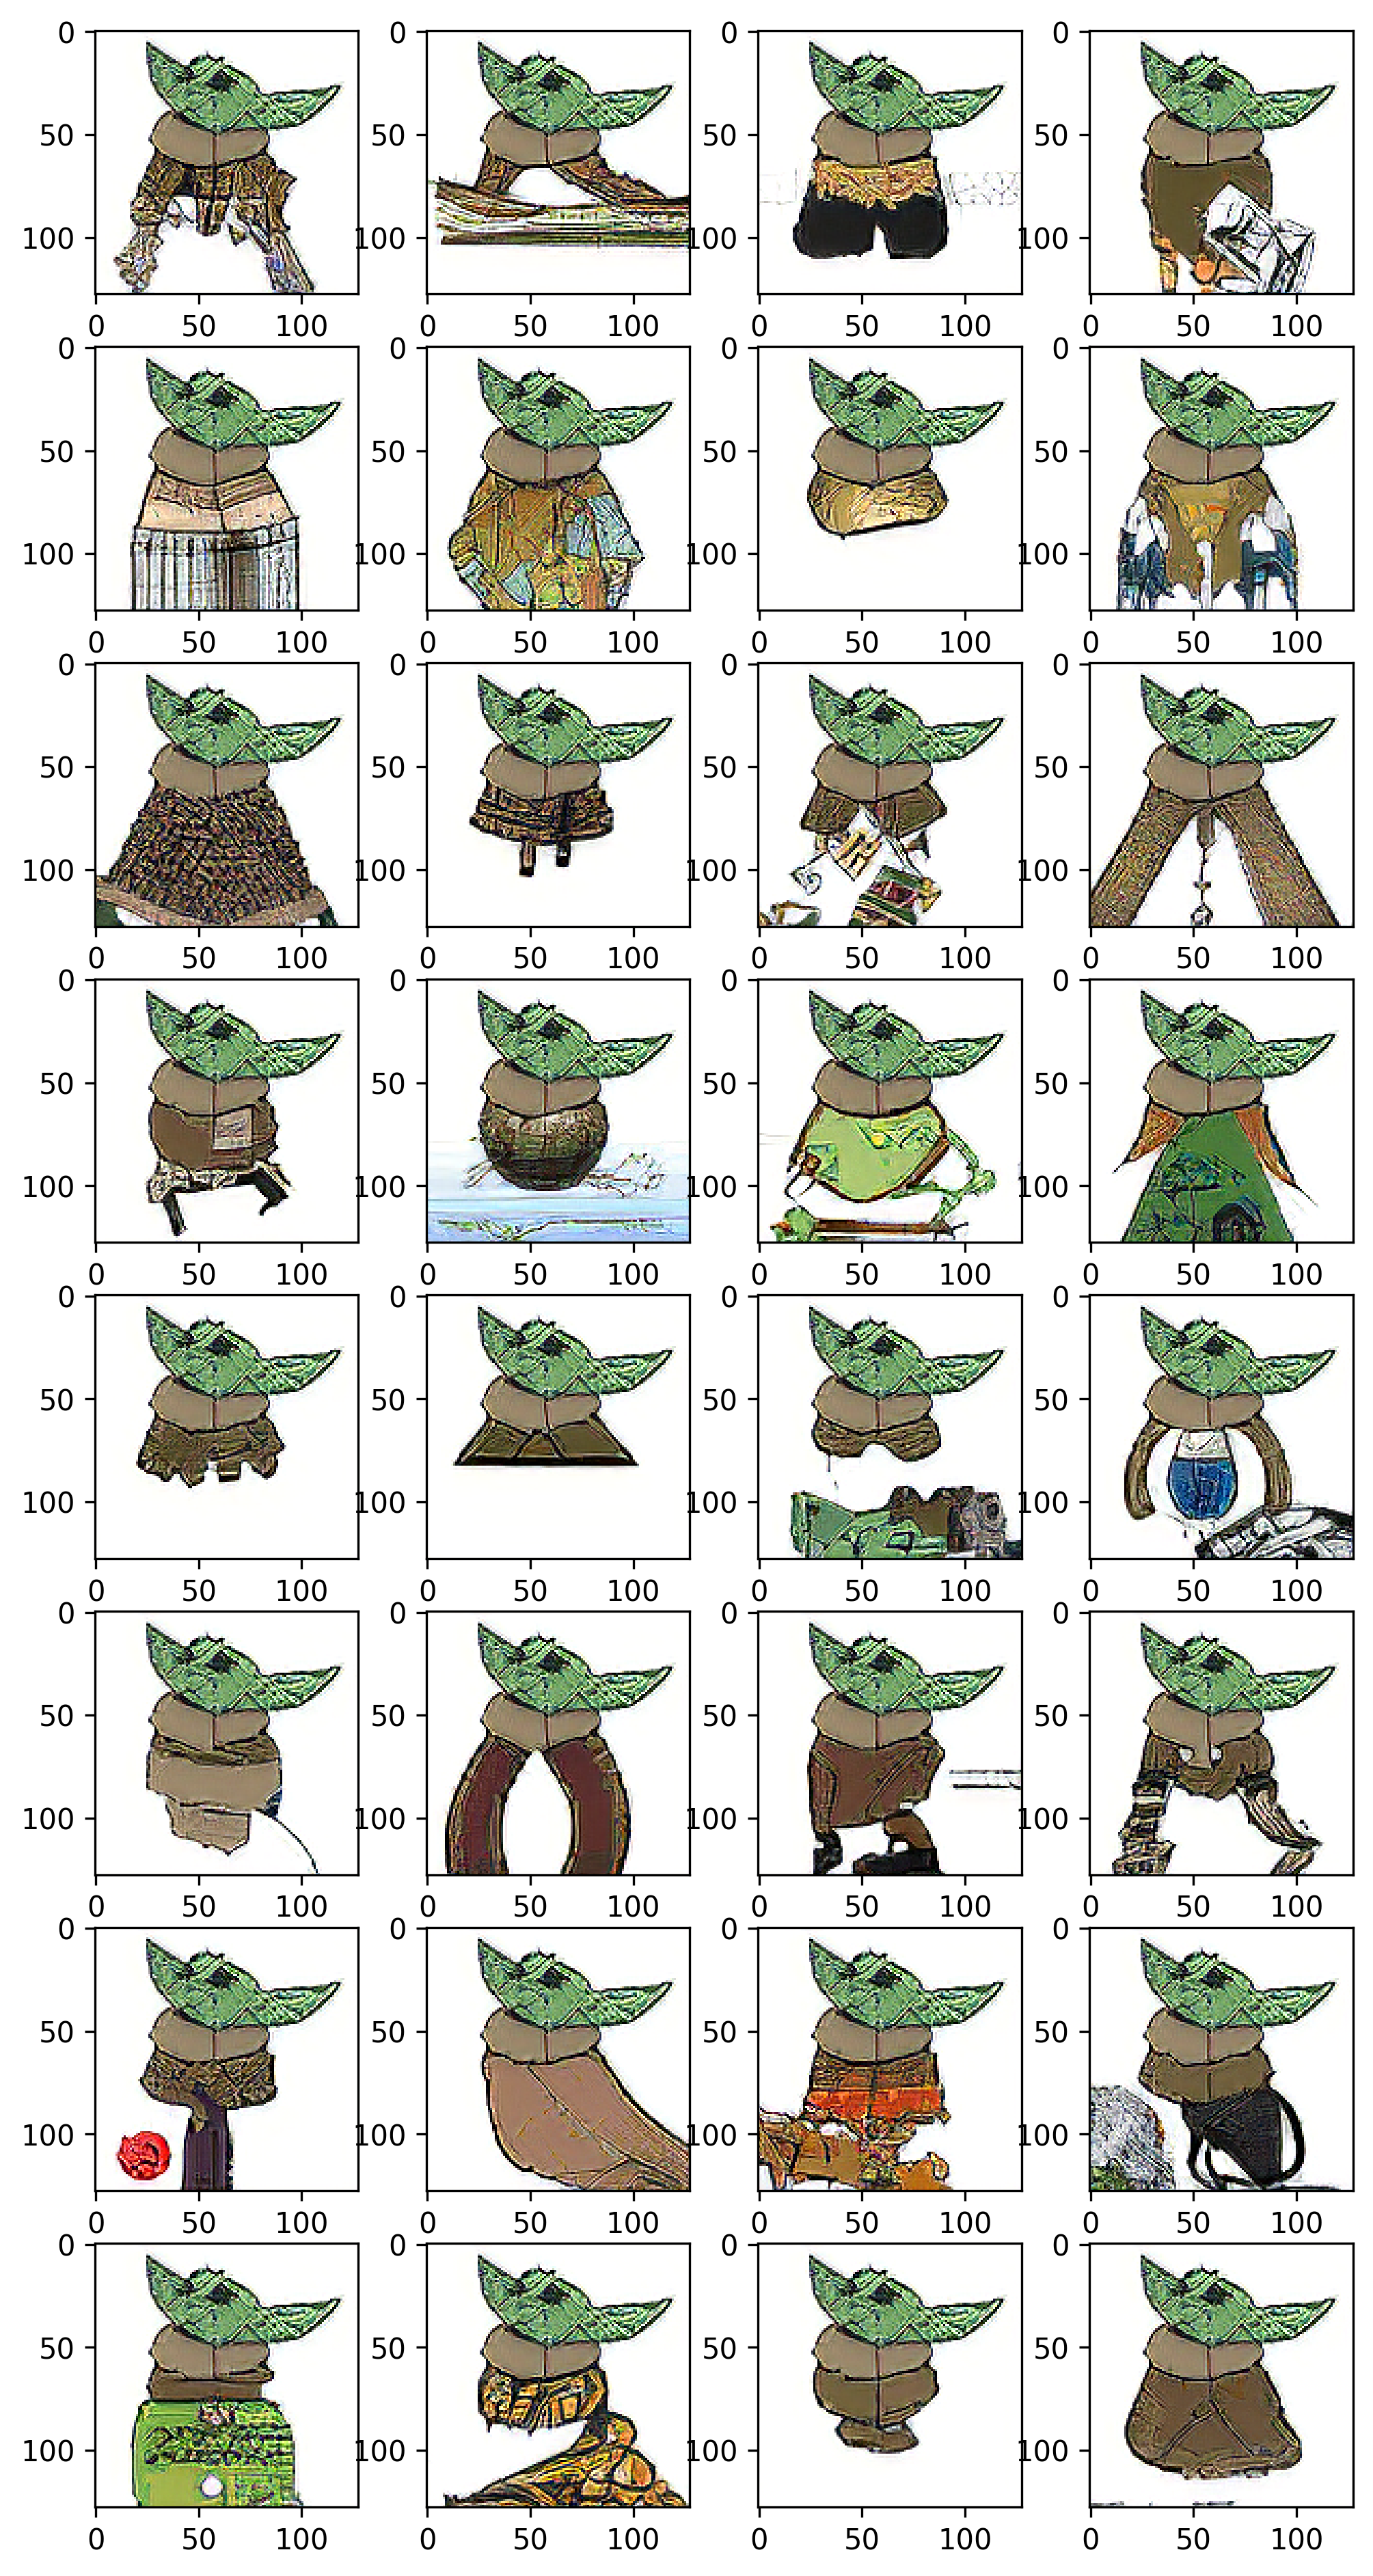

In [23]:

num_columns = 4
num_rows = int(gpus*n_samples/num_columns)
fig, ax = plt.subplots(num_rows,num_columns, dpi=300, figsize = (2*num_columns,2*num_rows))

i = 0
for i in range(num_rows):
    for j in range(num_columns):
        idx = i*num_columns+j
        source_path = f'inter/sample_{idx}_rlt.png'
        image = plt.imread(source_path)
        if num_rows > 1:
            ax[i, j].imshow(image, interpolation="none")
        else:
            ax[j].imshow(image, interpolation="none")
    i += 1
    
plt.show()